Equations for transient Euler-Bernoulli beam:

$$\mu \frac{d^2w}{dt^2} + \frac{d^2}{dx^2} \left( EI \frac{d^2w}{dx^2} \right) = q$$

$$-EI \frac{d^2w}{dx^2} = M$$

$$-\frac{d}{dx} \left( EI \frac{d^2w}{dx^2} \right) = Q$$

$E$: Young's modulus \
$I$: moment of inertia \
$\mu$: linear mass density




available hardware acceleration

In [1]:
import torch

n_devices = torch.cuda.device_count()
print(f"number of CUDA devices available: {n_devices}")
if n_devices > 1:
    for i in range(n_devices):
        device_name = f"cuda:{i}"
        device = torch.device(f"\"{device_name}\" ({torch.cuda.get_device_name(device='cuda')})")
        print(f"\t {device}")
else:
    print(f"\t \"cuda\" ({torch.cuda.get_device_name(device='cuda')})")
a = torch.tensor([1,2,3], device="cuda")

number of CUDA devices available: 1
	 "cuda" (Tesla M40 24GB)


## Data Driven Inference

define a class for the FFNN

In [2]:
import torch
import torch.nn as nn
import random
import time
import numpy as np
from IPython.display import display, clear_output, update_display
import matplotlib.pyplot as plt
%matplotlib widget

class FFNN(torch.nn.Module):
    def __init__(self, layers, nonlinearity="sigmoid", device="cpu"):
        super(FFNN, self).__init__()
        self.device = device
        
        self.layers = layers
        self.dtype = torch.float64
        
        self.layers = nn.ParameterDict({f"layer_{i}": nn.Linear(layer_i, layer_ip1, bias=(i < len(layers_widths) - 2), dtype=self.dtype, device=self.device) for i, (layer_i, layer_ip1) in enumerate(zip(layers_widths[:-1], layers_widths[1:]))})

        if nonlinearity == "sigmoid":
            self.nonlinearity = nn.Sigmoid()
        elif nonlinearity == "tanh":
            self.nonlinearity = nn.Tanh()
        elif nonlinearity == "relu":
            self.nonlinearity = nn.ReLU()
        elif nonlinearity == "leaky_relu":
            self.nonlinearity = nn.LeakyReLU()
        elif nonlinearity == "softplus":
            self.nonlinearity = nn.Softplus()
        else:
            raise ValueError("Invalid nonlinearity.")

    
    def forward(self, x):
        #print(f"shape of x: {x.shape}")
        y = x.to(self.device)
        for layer_index, layer_name in enumerate(self.layers):
            y = self.layers[layer_name](y)
            #print(f"shape of y: {y.shape}")
            # apply nonlinearity for all but the last layer
            if layer_index < len(self.layers) - 1:
                y = self.nonlinearity(y)
        
        return y.to("cpu")




definition of the beam model

In [3]:
# parameters
l = 1 # length of the beam (left end is at x=0)
E = lambda t,x: 1 # Young's modulus
I = lambda t,x: 1 # moment of inertia
mu = lambda t,x: 1 # linear mass density

dynamic = True # whether the simulation should include dnamic effects
t_end = 0.1 if dynamic else 0 # time, at which the simulation ends (start time is t=0)

n_samples_t = 3 if dynamic else 1
n_samples_x = 20

# boundary conditions
# clamped --> (w, w_x)
# free --> (Q, M)
# pinned --> (w, M)
bcs = {"left boundary": {"x": 0, "type": "clamped", "values": (0., 0.)},
       "right boundary": {"x": 1, "type": "free", "values": (0., 0.)}}
q = lambda x: 0.

# initial conditions
ics = {"w": lambda x: 3/10*1/6*(3*x**2 - x**3 + (x-1)**3), "w_t": lambda x: 0.}

#def batched_grad(inputs, outputs, create_graph):
#    print(f"input shape for batched gradients: {inputs.shape}")
#    print(inputs[0])
#    print(outputs[0])
#    return torch.stack([torch.autograd.grad(inputs=inputs[i], outputs=outputs[i], create_graph=create_graph) for i in range(len(inputs))])

def comp_loss(t, x, w):
    batch_shape = t.shape
    loss = {key: torch.tensor(0.) for key in ["pde", "w", "w_x", "Q", "M", "w_i", "w_t_i"]}

    # pde
    w_x = torch.autograd.grad(inputs=x, outputs=w, grad_outputs=torch.ones(batch_shape), create_graph=True, retain_graph=True)[0]
    w_xx = torch.autograd.grad(inputs=x, outputs=w_x, grad_outputs=torch.ones(batch_shape), create_graph=True, retain_graph=True)[0]

    eiw_xx = E(t,x)*I(t,x)*w_xx
    eiw_xx_x = torch.autograd.grad(inputs=x, outputs=eiw_xx, grad_outputs=torch.ones(batch_shape), create_graph=True, retain_graph=True)[0]
    eiw_xx_xx = torch.autograd.grad(inputs=x, outputs=eiw_xx_x, grad_outputs=torch.ones(batch_shape), create_graph=True, retain_graph=True)[0]

    w_t = torch.autograd.grad(inputs=t, outputs=w, grad_outputs=torch.ones(batch_shape), create_graph=True, retain_graph=True)[0]
    w_tt = torch.autograd.grad(inputs=t, outputs=w_t, grad_outputs=torch.ones(batch_shape), create_graph=True, retain_graph=True)[0]
    muw_tt = mu(t,x)*w_tt

    loss["pde"] = ((muw_tt*dynamic + eiw_xx_xx - q(x))**2).mean()

    # boundary conditions
    for bc_name in bcs:
        bc = bcs[bc_name]

        # initial conditions take precedence in the dynamic case
        if dynamic:
            boundary_mask = torch.logical_and(x == bc["x"], (t > 0))
        else:
            boundary_mask = x == bc["x"]

        if boundary_mask.sum() > 0:
            if bc["type"] == "clamped":
                loss["w"] = loss["w"] + ((w[boundary_mask] - bc["values"][0])**2).mean() # w
                loss["w_x"] = loss["w_x"] + ((w_x[boundary_mask] - bc["values"][1])**2).mean() # w_x
    
            elif bc["type"] == "free":
                loss["Q"] = loss["Q"] + ((-eiw_xx_x[boundary_mask] - bc["values"][0])**2).mean() # Q
                loss["M"] = loss["M"] + ((-eiw_xx[boundary_mask] - bc["values"][1])**2).mean() # M

            elif bc["type"] == "pinned":
                loss["w"] = loss["w"] + ((w[boundary_mask] - bc["values"][0])**2).mean() # w
                loss["M"] = loss["M"] + ((-eiw_xx[boundary_mask] - bc["values"][1])**2).mean() # M
            else:
                raise ValueError(f"invalid type of boundary condition: {bc['type']}")

    # initial conditions
    if dynamic:
        ic_mask = t == 0.
        #print(x[ic_mask])
        #print(ics["w"](x[ic_mask]))
        if ic_mask.sum() > 0:
            loss["w_i"] = loss["w_i"] + ((w[ic_mask] - ics["w"](x[ic_mask]))**2).mean() # w
            loss["w_t_i"] = loss["w_t_i"] + ((w_t[ic_mask] - ics["w_t"](x[ic_mask]))**2).mean() # w_t
    
    
    return loss

meshgrid = torch.meshgrid(torch.linspace(0, t_end, n_samples_t),
                           torch.linspace(0, l, n_samples_x))
points_t = meshgrid[0].reshape(-1,1)
points_x = meshgrid[1].reshape(-1,1)



/home/jovyan/.conda/envs/paml_env_pytorch/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971132/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


class for visualization

In [4]:
class Visualization:
    def __init__(self, model, l, t_end, plot_interval=10, dynamic=True):
        self.model=model
        self.l = l
        self.t_end = t_end
        self.plot_interval = plot_interval
        self.dynamic = dynamic
        self.deflection_limits = None

        self.fig = self.axs = None
        self.vis_data = None
        self.figsize = (8, 10)

    
    def vis(self, vis_data):
        vis_data = {plot_key: {key: [value] for key, value in zip(plot_data.keys(), plot_data.values())} for plot_key, plot_data in zip(vis_data.keys(), vis_data.values())}
        if self.vis_data is None or not len(vis_data) == len(self.vis_data):
            self.vis_data = vis_data
            self.fig, self.axs = plt.subplots(len(vis_data) + 1, 1, figsize=self.figsize)
            self.display_id = 'display_id'+str(random.random())
            display(self.fig, display_id=self.display_id)
        else:
            for plot_key in vis_data:
                for data_field in vis_data[plot_key]:
                    self.vis_data[plot_key][data_field] += vis_data[plot_key][data_field]

        if (iter_index + 1) % self.plot_interval == 0:
            for plot_index, plot_key in enumerate(self.vis_data):

                title = plot_key
                data_x = list(self.vis_data[plot_key].values())[0]
                data_y = list(self.vis_data[plot_key].values())[1]
                label_x = list(self.vis_data[plot_key].keys())[0]
                label_y = list(self.vis_data[plot_key].keys())[1]
                self.axs[plot_index].clear()
                self.axs[plot_index].plot(data_x, data_y)
                self.axs[plot_index].set_xlabel(label_x)
                self.axs[plot_index].set_ylabel(label_y)
                self.axs[plot_index].set_yscale("log" if "loss" in label_y else "linear")
                self.axs[plot_index].set_title(title)
                self.axs[plot_index].grid(True)

                plot_index = len(self.vis_data)
                self.axs[plot_index].clear()
                if self.deflection_limits is not None:
                    deflection_delta = self.deflection_limits[1] - self.deflection_limits[0]
                    self.deflection_limits[0] = self.deflection_limits[0] + deflection_delta*0.01
                    self.deflection_limits[1] = self.deflection_limits[1] - deflection_delta*0.01
            for t_i in np.linspace(0, self.t_end, 3 if self.dynamic else 1):
                x_eval = torch.linspace(0, self.l, 100, dtype=self.model.dtype).reshape(-1,1)
                t_eval = t_i*torch.ones_like(x_eval, dtype=self.model.dtype).reshape(-1,1)
                self.model.eval()
                w_eval = self.model(torch.concatenate([t_eval, x_eval], dim=1)).detach()

                if self.deflection_limits is None:
                    self.deflection_limits = [w_eval.min(), w_eval.max()]
                else:
                    self.deflection_limits[0] = min(w_eval.min(), self.deflection_limits[0])
                    self.deflection_limits[1] = max(w_eval.max(), self.deflection_limits[1])
    
                self.axs[plot_index].plot(x_eval, w_eval, label=f"t={t_i:.2f}")
                
            self.axs[plot_index].set_xlabel("x in m")
            self.axs[plot_index].set_ylabel("w in m")
            deflection_delta = self.deflection_limits[1] - self.deflection_limits[0]
            self.axs[plot_index].set_ylim([self.deflection_limits[0] - 0.1*deflection_delta, self.deflection_limits[1] + 0.1*deflection_delta])
            self.axs[plot_index].set_title("deflection for different points in time")
            self.axs[plot_index].grid(True)
            if self.dynamic:
                self.axs[plot_index].legend()

            
            plt.tight_layout()
            update_display(self.fig, display_id=self.display_id)
            #plt.savefig('training_plot_cnn.svg', format='svg')
            #plt.pause(0.1)
            
            #print(f"w_x_mean_actual: {w_eval[x_eval == x_eval.max()].mean() - w_eval[x_eval == x_eval.min()].mean()}")



training

ParameterDict(
    (layer_0): Object of type: Linear
    (layer_1): Object of type: Linear
    (layer_2): Object of type: Linear
    (layer_3): Object of type: Linear
  (layer_0): Linear(in_features=2, out_features=100, bias=True)
  (layer_1): Linear(in_features=100, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=False)
)


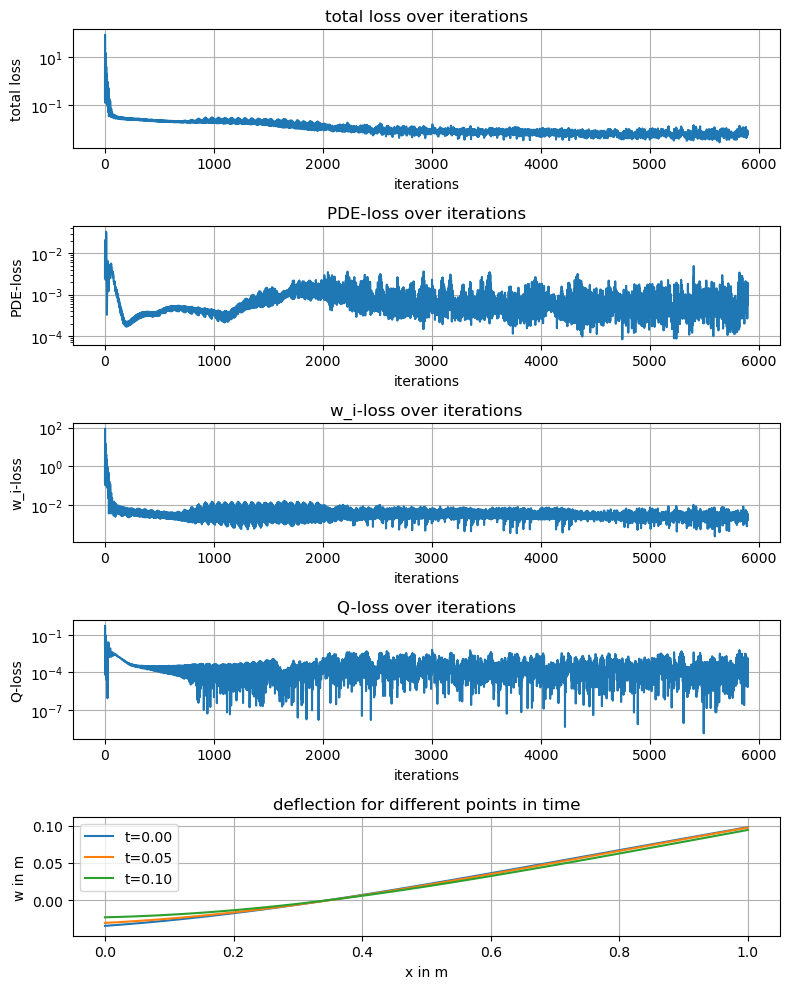

new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5.00e-03
new learning rate: 5

KeyboardInterrupt: 

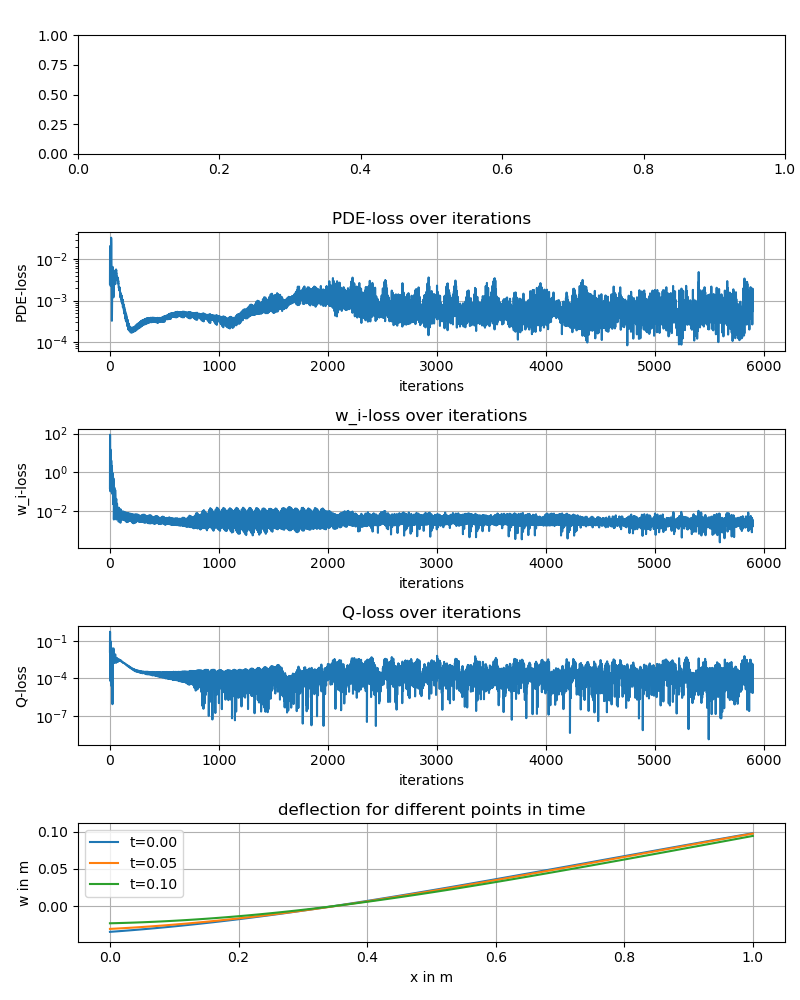

In [7]:
torch.manual_seed(0) # ensure reproducibility

layers_widths = [2, 100, 100, 100, 1]

ffnn = FFNN(layers_widths, nonlinearity="tanh", device="cpu")

print(ffnn.layers)
#print(list(ffnn.layers["layer_0"].parameters())[0])
#print(list(ffnn.layers["layer_1"].parameters())[0])
#print(list(ffnn.layers["layer_2"].parameters())[0])
#time.sleep(100)

optimizer = torch.optim.Adam(params=ffnn.parameters(), lr=0.005, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.)

visualization = Visualization(model=ffnn, l=l, t_end=t_end, plot_interval=50, dynamic=dynamic)

x = points_x.type(ffnn.dtype).requires_grad_()
t = (points_t).type(ffnn.dtype).requires_grad_()

#print(t)

batch_size = n_samples_t*n_samples_x - 11
def get_batch(data, iter_index, batch_size):
    data_len = len(data[0])
    start_index = (iter_index*batch_size) % data_len
    stop_index = ((iter_index + 1)*batch_size) % data_len

    batch_data = []
    for input in data:
        if start_index < stop_index:
            batch_data.append(input[start_index:stop_index])
        else:
            batch_data.append(torch.concatenate([input[start_index:], input[:stop_index]], dim=0))

    return tuple(batch_data)

maxiter = np.inf
        
iter_index = 0
scheduler_index = 0
while True:
    #print(f"iteration {iter_index + 1}")
    ffnn.zero_grad()
    ffnn.train()

    t_i, x_i = get_batch([t, x], iter_index, batch_size)
    #t_i = t[iter_index % len(t)].reshape(1,1)
    #x_i = x[iter_index % len(t)].reshape(1,1)
    w = ffnn(torch.concatenate([t_i, x_i], dim=1))

    #w_x = torch.autograd.grad(inputs=x_i, outputs=w, create_graph=True, retain_graph=True)[0]
    #print(f"x_i: {x_i}")
    #print(f"w: {w}")
    #print(f"w_x: {w_x}")
    
    losses = comp_loss(t_i, x_i, w)
    
    loss_sum = sum(losses.values()) # !!!!!!!!!!!!!!!!!make it so the losses have the same orders of magnitude?!!!!!!!!!!!!!!!!
    loss_normalized = 0.
    #norm_value = torch.concatenate([v.reshape(1,1) for v in losses.values()]).max()
    #print(f"max loss: {norm_value}")
    tolerances = {"pde": 1e-2, "w": 1e-2, "w_x": 1e-2, "Q": 1e-2, "M": 1e-2, "w_i": 1e-5, "w_t_i": 1e-4}
    for loss_key, loss_comp in zip(losses.keys(), losses.values()):
        if loss_comp > 0:
            loss_normalized = loss_normalized + loss_comp /(loss_comp.detach() + tolerances[loss_key])

    losses["pde"] = 1.*losses["pde"]
    losses["w"] = 1.*losses["w"]
    losses["w_x"] = 1.*losses["w_x"]
    losses["Q"] = 10.*losses["Q"]
    losses["M"] = 1.*losses["M"]
    losses["w_i"] = 1e2*losses["w_i"]
    losses["w_t_i"] = 1.*losses["w_t_i"]

    loss_normalized = sum(losses.values())
    #print(f"loss: {loss}")
    loss_normalized.backward()
    optimizer.step()

    #print(f"gradient: {list(ffnn.layers['layer_1'].parameters())[0].grad}")

    #print(f"loss: {loss}")
    #print(iter_index)
    #print(loss)
    vis_data = {"total loss over iterations": {"iterations": iter_index+1, "total loss": loss_normalized.detach()},
                "PDE-loss over iterations": {"iterations": iter_index+1, "PDE-loss": losses["pde"].detach()},
                "w_i-loss over iterations": {"iterations": iter_index+1, "w_i-loss": losses["w_i"].detach()},
                "Q-loss over iterations": {"iterations": iter_index+1, "Q-loss": losses["Q"].detach()}}
    visualization.vis(vis_data)

    iter_index += 1

    scheduler_index += batch_size
    if scheduler_index > len(t):
        scheduler_index = scheduler_index % len(t)
        lr_scheduler.step()
        print(f"new learning rate: {lr_scheduler.get_last_lr()[0]:.2e}")

    if iter_index == maxiter:
        break

#grad_x = torch.autograd.grad(inputs=x, outputs=y, create_graph=True) # create graph for gradients, so that they can be used in the loss function    

#print(f"gradient of x: {grad_x}")

print("done")

## parameter Identification